In [1]:
import os
import pandas as pd
import torch
import numpy as np
import cv2

from inference import leish_dict_per_image, prepare_model, inference, preprocessing_image


In [2]:
PATH = 'GABARITO'
PLACA = '013 16 1'
THRESHOLD_LEISHMANIA = 0.15
THRESHOLD_MACROFAGO_CONTAVEL = 0.3
CHECKPOINT_PATH = 'lightning_logs/version_0/checkpoints/epoch=18-step=3096.ckpt'

FOLDER_LIST = os.listdir(os.path.join(PATH, PLACA))

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


model = prepare_model(CHECKPOINT_PATH, device=DEVICE)


LOADING THE MODEL CHECKPOINT


Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_he

Model loaded to cuda:0!


In [3]:
### INFERENCE ON GABARITO

indices_table = {}
writer = pd.ExcelWriter(os.path.join('', PLACA+'.xlsx'), engine='xlsxwriter')
for folder in FOLDER_LIST:
    image_list = os.listdir(os.path.join(PATH, PLACA, folder))

    # reset dataframe
    dataframe_results = pd.DataFrame()

    for image in image_list:
        
        # LOADING IMAGE
        img = cv2.imread(os.path.join(PATH, PLACA, folder, image))
        
        assert isinstance(img, np.ndarray), "Error in loading Image"

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_copy = img.copy()

        # PRE PROCESSING STEPS
        

        # INFERENCE 
        print('Realizando inferencia na imagem: ', image)
        outputs = inference(model=model, image=img, device=DEVICE)

        ## THRESHOLD SECTION
        leishmania_segmentation = outputs['leishmania'] > THRESHOLD_LEISHMANIA
        contable_segmentation = outputs['macrofago contavel'] > THRESHOLD_MACROFAGO_CONTAVEL

        # POS PROCESSING TO COUNT LEISHMANIA ONLY WITH CONTABLE MACROPHAGES
        leish_dict = leish_dict_per_image(contable_segmentation=contable_segmentation,leish_segmentation=leishmania_segmentation)

        
        # STORING RESULTS
        results = {'Contagem': leish_dict, 'Imagem': image} # 'Laminula': folder, 'Placa': PLACA}
        df_conts = pd.DataFrame.from_dict(results)
        dataframe_results = pd.concat([dataframe_results, df_conts])
 

    # WRITING IN EXCEL
    dataframe_results.to_excel(writer, sheet_name=folder)

    
    

    # COUNTING MACROPHAGES ONLY WITH LEISHMANIA
    quantidade_macrofago_com_leish = (dataframe_results['Contagem'] != 0).sum()
    total_leish = dataframe_results['Contagem'].sum()
    # INFECTION RATIO
    infection_ratio = total_leish/quantidade_macrofago_com_leish
    # STORING RESULTS FOR EACH INFECTION RATIO
    indices_table[folder] = {'Indice de infecção': infection_ratio, 'Quantidade de leishmania': total_leish,
        'Quantidade de macrofagos com leishmania': quantidade_macrofago_com_leish, 'Total de Macrofagos': len(dataframe_results)
    }
    
    
dataframe_ratio_infections = pd.DataFrame.from_dict(indices_table)
dataframe_ratio_infections.to_excel(writer, sheet_name='FINAL')

writer.close()


Realizando inferencia na imagem:  20.jpg
Realizando inferencia na imagem:  21.jpg
Realizando inferencia na imagem:  22.jpg
Realizando inferencia na imagem:  23.jpg
Realizando inferencia na imagem:  24.jpg
Realizando inferencia na imagem:  25.jpg
Realizando inferencia na imagem:  26.jpg
Realizando inferencia na imagem:  27.jpg
Realizando inferencia na imagem:  28.jpg
Realizando inferencia na imagem:  29.jpg
Realizando inferencia na imagem:  30.jpg
Realizando inferencia na imagem:  31.jpg
Realizando inferencia na imagem:  32.jpg
Realizando inferencia na imagem:  33.jpg
Realizando inferencia na imagem:  34.jpg
Realizando inferencia na imagem:  35.jpg
Realizando inferencia na imagem:  36.jpg
Realizando inferencia na imagem:  37.jpg
Realizando inferencia na imagem:  38.jpg
Realizando inferencia na imagem:  39.jpg
Realizando inferencia na imagem:  201.jpg
Realizando inferencia na imagem:  202.jpg
Realizando inferencia na imagem:  203.jpg
Realizando inferencia na imagem:  204.jpg
Realizando i

In [21]:
from inference import generate_contable_roi

bbox = generate_contable_roi(contable_segmentation.cpu())

In [27]:
bbox[1]

{'Xmin': 610, 'Xmax': 655, 'Ymin': 202, 'Ymax': 250}

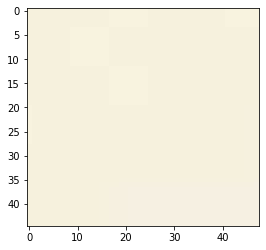

In [26]:
import matplotlib.pyplot as plt
from inference import remove_bg
roi = bbox[1]
plt.imshow(remove_bg(img)[roi['Xmin']: roi['Xmax'], roi['Ymin']: roi['Ymax']])

In [63]:
from skimage.measure import find_contours

contours = find_contours(contable_segmentation.cpu().numpy())

bounding_boxes = []
for contour in contours:
    contour = contour.astype(int)
    print(contour)
    Xmin = np.min(contour[:, 1])
    Xmax = np.max(contour[:, 1])
    Ymin = np.min(contour[:, 0])
    Ymax = np.max(contour[:, 0])

    # FILTRO PASSA ALTA DE BBOX (RETIRAR RUÍDOS COM COMPRIMENTO MENOR DO QUE 20 PX)
    if Xmax - Xmin > 20 and Ymax - Ymin > 20:
        bounding_boxes.append(
            {'Xmin': Xmin, 'Xmax': Xmax, 'Ymin': Ymin, 'Ymax': Ymax})
    break

[[236 134]
 [236 133]
 [236 132]
 [235 132]
 [235 131]
 [235 130]
 [235 129]
 [235 128]
 [235 127]
 [234 127]
 [234 126]
 [234 125]
 [234 124]
 [233 124]
 [233 123]
 [233 122]
 [233 121]
 [232 121]
 [232 120]
 [232 119]
 [232 118]
 [231 118]
 [231 117]
 [231 116]
 [230 116]
 [230 115]
 [230 114]
 [229 114]
 [229 113]
 [229 112]
 [229 111]
 [229 110]
 [228 110]
 [228 109]
 [228 108]
 [228 107]
 [227 107]
 [227 106]
 [227 105]
 [227 104]
 [226 104]
 [226 103]
 [226 102]
 [225 102]
 [225 101]
 [225 100]
 [224 100]
 [224  99]
 [224  98]
 [223  98]
 [223  97]
 [223  96]
 [222  96]
 [222  95]
 [221  95]
 [221  94]
 [220  94]
 [219  94]
 [219  93]
 [218  93]
 [217  93]
 [217  92]
 [216  92]
 [215  92]
 [214  92]
 [213  92]
 [212  92]
 [212  91]
 [211  91]
 [210  91]
 [209  91]
 [208  91]
 [207  91]
 [206  91]
 [205  91]
 [204  91]
 [203  91]
 [202  91]
 [201  91]
 [200  92]
 [200  92]
 [199  92]
 [198  93]
 [198  93]
 [197  93]
 [196  93]
 [195  94]
 [195  94]
 [194  94]
 [193  94]
 [192  95]

[[236.5 134. ]
 [236.5 133. ]
 [236.  132.5]
 [235.5 132. ]
 [235.5 131. ]
 [235.5 130. ]
 [235.5 129. ]
 [235.5 128. ]
 [235.  127.5]
 [234.5 127. ]
 [234.5 126. ]
 [234.5 125. ]
 [234.  124.5]
 [233.5 124. ]
 [233.5 123. ]
 [233.5 122. ]
 [233.  121.5]
 [232.5 121. ]
 [232.5 120. ]
 [232.5 119. ]
 [232.  118.5]
 [231.5 118. ]
 [231.5 117. ]
 [231.  116.5]
 [230.5 116. ]
 [230.5 115. ]
 [230.  114.5]
 [229.5 114. ]
 [229.5 113. ]
 [229.5 112. ]
 [229.5 111. ]
 [229.  110.5]
 [228.5 110. ]
 [228.5 109. ]
 [228.5 108. ]
 [228.  107.5]
 [227.5 107. ]
 [227.5 106. ]
 [227.5 105. ]
 [227.  104.5]
 [226.5 104. ]
 [226.5 103. ]
 [226.  102.5]
 [225.5 102. ]
 [225.5 101. ]
 [225.  100.5]
 [224.5 100. ]
 [224.5  99. ]
 [224.   98.5]
 [223.5  98. ]
 [223.5  97. ]
 [223.   96.5]
 [222.5  96. ]
 [222.   95.5]
 [221.5  95. ]
 [221.   94.5]
 [220.   94.5]
 [219.5  94. ]
 [219.   93.5]
 [218.   93.5]
 [217.5  93. ]
 [217.   92.5]
 [216.   92.5]
 [215.   92.5]
 [214.   92.5]
 [213.   92.5]
 [212.5  9

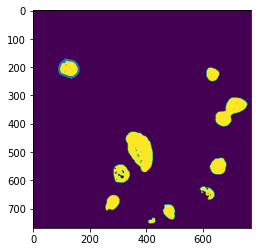

In [64]:
fig, ax = plt.subplots()

for contour in contours:
    print(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    break
plt.imshow(contable_segmentation.cpu().numpy())

In [65]:
bounding_boxes
bbox = bounding_boxes[0]
coords = bbox['Xmin'], bbox['Ymin']

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = 2
thickness = 2

In [66]:
t = contable_segmentation.cpu().numpy().astype(np.uint8)

t = cv2.putText(t, 'A', coords, font,fontScale, color, thickness, cv2.LINE_AA)


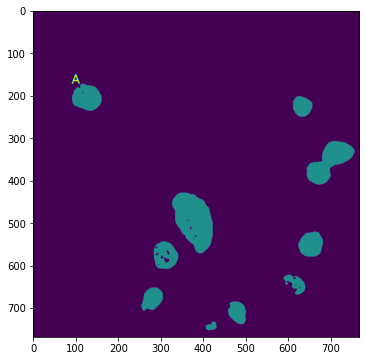

In [69]:
plt.figure(figsize=(12,6))
plt.imshow(t)

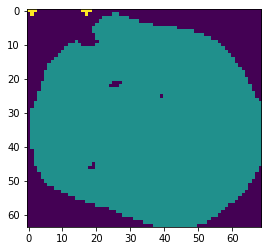

In [72]:
plt.imshow(t[bbox['Ymin']:bbox['Ymax'], bbox['Xmin']: bbox['Xmax']])